In [447]:
import ndlib
import networkx as nx
import ndlib.models.epidemics as ep
import json
import ndlib.models.ModelConfig as mc
import numpy as np
import math
import random

import matplotlib.pyplot as plt
%matplotlib inline
import tkinter


from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

## Gillespie's direct algorithm ##
From the site of the book


In [448]:
####################################################################
###    This is the PYTHON version of program 6.4 from page 203 of  #
### "Modeling Infectious Disease in humans and animals"            #
### by Keeling & Rohani.										   #
###																   #
### It is the SIR model (including births and deaths) with full    #
### (event-driven) demographic stochasticity.					   #
###																   #
### This is a more complex stochastic model as 6 events are		   #
### possible: infection, recovery, birth, death of susceptible,    #
### death of infected, death of recovered.					       #
### Note: by default we are using a very small population size 	   #
### to highlight the stochasticity.				   				   #
####################################################################

###################################
### Written by Ilias Soumpasis    #
### ilias.soumpasis@ucd.ie (work) #
### ilias.soumpasis@gmail.com	  #
###################################

import numpy as np
import pylab as pl

beta=1.0
gamma=1/7.0
mu=1/70
N0=500
delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)
### You may want to try with popylation size of 50 (small) to see the events
### In this case uncomment the next line
#N0=50.0
ND=MaxTime=2*365.0
Y0=pl.ceil(mu*N0/gamma)
X0=pl.floor(gamma*N0/beta)
# Y0=5
# X0=8000
Z0=N0-X0-Y0

INPUT = np.array((X0,Y0,Z0))

timestep=0.0

def stoc_eqs(INP,ts): 
	V = INP
	Rate=np.zeros((7))
	Change=np.zeros((7,3))
	N=np.sum(V[range(3)])
	Rate[0] = beta*V[0]*V[1]/N; Change[0,:]=([-1, +1, 0]);
	Rate[1] = gamma*V[1];  Change[1,:]=([0, -1, +1]);
	Rate[2] = mu*N;  Change[2,:]=([+1, 0, 0]);
	Rate[3] = mu*V[0];  Change[3,:]=([-1, 0, 0]);
	Rate[4] = mu*V[1];  Change[4,:]=([0, -1, 0]);
	Rate[5] = mu*V[2];  Change[5,:]=([0, 0, -1]);
	Rate[6] = delta;  Change[6,:]=([0, +1, 0]);
	R1=pl.rand();
	R2=pl.rand();
	ts = -np.log(R2)/(np.sum(Rate));
	list1 = np.cumsum(Rate)
	for i in range(len(list1)):
		if list1[i] >= R1*np.sum(Rate):
			V[range(3)] = V[range(3)]+Change[i,:]
			return [V,ts]


def Stoch_Iteration(INPUT):
    lop=0
    ts=0
    T=[0]
    S=[0]
    I=[0]
    R=[0]
    while T[lop] < ND:
        lop=lop+1
        T.append(T[lop-1]+ts)
        S.append(INPUT[0])
        I.append(INPUT[1])
        R.append(INPUT[2])
        [res,ts] = stoc_eqs(INPUT,ts)
#         lop=lop+1
#         T.append(T[lop-1])
#         S.append(INPUT[0])
#         I.append(INPUT[1])
#         R.append(INPUT[2])
    return [T,S,I,R]

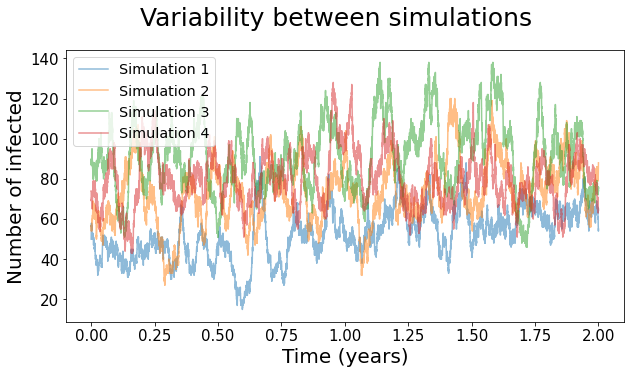

In [460]:
## Variability ##

beta=1.0
gamma=1/7.0
mu=1/70
N0=500
delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)
ND=MaxTime=2*365.0
Y0=pl.ceil(mu*N0/gamma)
X0=pl.floor(gamma*N0/beta)
Z0=N0-X0-Y0

INPUT = np.array((X0,Y0,Z0))

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (10,5))
for i in range(4):
    [T,S,I,R]=Stoch_Iteration(INPUT)

    tT=np.array(T)[1:,]/365.
    tS=np.array(S)[1:,]
    tI=np.array(I)[1:,]
    tR=np.array(R)[1:,]

    ax2.plot(tT, tI, alpha=0.5, label=('Simulation %s' %(i+1)))
    ax2.set_ylabel("Number of infected", size = 20)
    
plt.legend(loc = "upper left", fontsize = "x-large")
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
fig.suptitle('Variability between simulations', size = 25, y = 1)
plt.xlabel ('Time (years)', size = 20)
plt.show()

R0 is:  10.0
3.913894324853229e-05


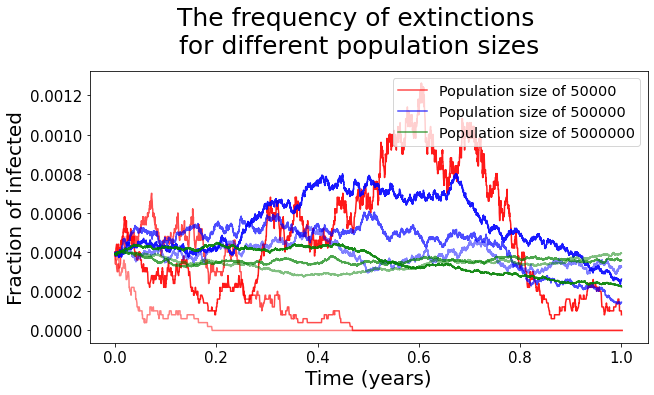

In [459]:
## Extinctions for different population size ##

beta=1
gamma=1/10.0
R0 = beta/gamma
print("R0 is: ", R0)
mu=1/(70*365)
print(mu)
# delta = 0.0005
Nlist = [50000, 500000, 5000000]

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (10, 5))
color = ['red', 'blue', 'green']

for Nvalue in range(3):
    N0 = Nlist[Nvalue]
    alfa = 0.9
#     print(N0)
    for iteration in range(3):
#         print(iteration)
        Y0=pl.ceil(mu*N0/gamma)
        X0=pl.floor(gamma*N0/beta)
        Z0=N0-X0-Y0
        ND=MaxTime=365.0
        INPUT = np.array((X0,Y0,Z0))
        delta = 0
        
        [T,S,I,R]=Stoch_Iteration(INPUT)

        tT=np.array(T)[1:,]/365.
        tS=np.array(S)[1:,]
        tI=np.array(I)[1:,]
        tR=np.array(R)[1:,]
        tN = tS + tI + tR

        if iteration == 1:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[Nvalue], label=('Population size of %s' %(N0)))
        else:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[Nvalue])
        ax2.set_ylabel("Fraction of infected", size = 20)
        alfa = alfa - 0.2
    
plt.legend(loc = "upper right", fontsize = "x-large", bbox_to_anchor = (1,1))
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
fig.suptitle('The frequency of extinctions \n for different population sizes ', size = 25, y = 1.06)
plt.xlabel ('Time (years)', size = 20)
plt.show()

1.25
1.25


KeyboardInterrupt: 

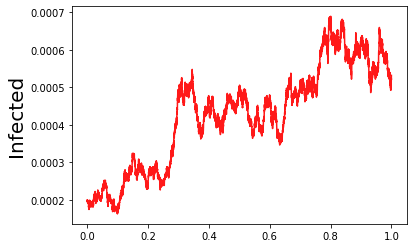

In [461]:
## Extinctions for different R0 ##

betalist = [0.25, 0.5, 1, 2, 4]
gammalist = [1/5, 1/5, 1/5, 1/5, 1/5]
# R0 = beta/gamma
# print("R0 is: ", R0)
mu=1/(70*365)
# delta = 0.0005
N0 = 500000

fig, (ax2) = plt.subplots(1, sharex=True)
color = ['red', 'blue', 'green', 'gray']

for R0value in range(3):
    beta = betalist[R0value]
    gamma = gammalist[R0value]
    alfa = 0.9
    for iteration in range(3):
        Y0=pl.ceil(mu*N0/gamma)
#         Y0 = 1
        X0=pl.floor(gamma*N0/beta)
        Z0=N0-X0-Y0
        ND=MaxTime=365.0
        INPUT = np.array((X0,Y0,Z0))
        delta = 0.0625*mu*(beta/gamma -1)*math.sqrt(N0)

#         delta = 0.0005
        print(beta/gamma)

        [T,S,I,R]=Stoch_Iteration(INPUT)


        tT=np.array(T)[1:,]/365.
        tS=np.array(S)[1:,]
        tI=np.array(I)[1:,]
        tR=np.array(R)[1:,]
        tN = tS + tI + tR

        if iteration == 1:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[R0value], label=('Iteration with R0: %s' %(beta/gamma)))
        else:
            ax2.plot(tT, tI/tN, alpha=alfa, color = color[R0value])
        ax2.set_ylabel("Infected", size = 20)
        alfa = alfa - 0.2
    
plt.legend(loc = "upper right", fontsize = "x-large", bbox_to_anchor = (1.8,1))
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
fig.suptitle('The frequency of extinctions \n for different R0 ', size = 25, y = 1.06)
plt.xlabel ('Time (years)', size = 20)
plt.show()

## Metapopulation with stochasticity 

In [462]:
def stoc_eqs_met(INP,ts): 
    V = INP
#     print(V)
    Change=np.zeros((nsub,6,3))
#     print(Change)
    sumlambda = np.zeros((nsub))
    Rate=np.zeros((nsub,6))
    for sub in range(nsub): 
#         print(sub)
        N=np.sum(V[sub])
#         print(sumlambda)
        for subs in range(nsub):
#             print(sub)
#             print(subs)
            if N == 0:
                sumlambda[sub] = 0 
#             print(V[sub][1])
#             print(rho[sub][subs]*V[subs][1]/N)
            sumlambda[sub] += rho[sub][subs]*V[subs][1]/N
        Rate[sub][0] = beta*sumlambda[sub]*V[sub][0]; Change[sub][0,:]=([-1, +1, 0]);
        Rate[sub][1] = gamma*V[sub][1];  Change[sub][1,:]=([0, -1, +1]);
        Rate[sub][2] = mu*N;  Change[sub][2,:]=([+1, 0, 0]);
        Rate[sub][3] = mu*V[sub][0];  Change[sub][3,:]=([-1, 0, 0]);
        Rate[sub][4] = mu*V[sub][1];  Change[sub][4,:]=([0, -1, 0]);
        Rate[sub][5] = mu*V[sub][2];  Change[sub][5,:]=([0, 0, -1]);
    R1=pl.rand();
#     print(Rate)
    list1 = np.cumsum(Rate)
#     print(list1)
#     print(V)
#     print(Change)
    
    for i in range(len(list1)):
#             print(i)
        if list1[i] >= R1*np.sum(Rate):
#             print(i)
            sub = i//6
#             print(sub)
#             for compartment in range(3):
#                 print(compartment)
#                 print(V)
# #                     print(i)
# #                     print(Change)
#                 V[sub][compartment] = V[sub][compartment]+Change[i][compartment]
#             print(V)
            V[sub] = V[sub]+Change[sub][i%6]
            break
    R2=pl.rand();
    ts = -np.log(R2)/(np.sum(Rate));
#     print(V)
    return [V,ts]


def Stoch_Iteration_met(INPUT):
    lop=0
    ts=0
    T=[0]
    S=[[0] for x in range(nsub)]
    I=[[0] for x in range(nsub)]
    R=[[0] for x in range(nsub)]
    while T[lop] < ND:
        lop=lop+1
        T.append(T[lop-1]+ts)
        for sub in range(nsub):
#             print(INPUT[sub][0])
            S[sub].append(INPUT[sub][0])
            I[sub].append(INPUT[sub][1])
#             print(sub)
#             print(INPUT)
            R[sub].append(INPUT[sub][2])
        [INPUT,ts] = stoc_eqs_met(INPUT,ts)
#         print(INPUT[2])
#         lop=lop+1
#         T.append(T[lop-1])
#         print(T[lop-1])
    return [T,S,I,R]


## For 2 populations

[[1.   0.01]
 [0.01 1.  ]]


<ipython-input-462-82ffc6812430>:49: RuntimeWarning: divide by zero encountered in double_scalars
  ts = -np.log(R2)/(np.sum(Rate));


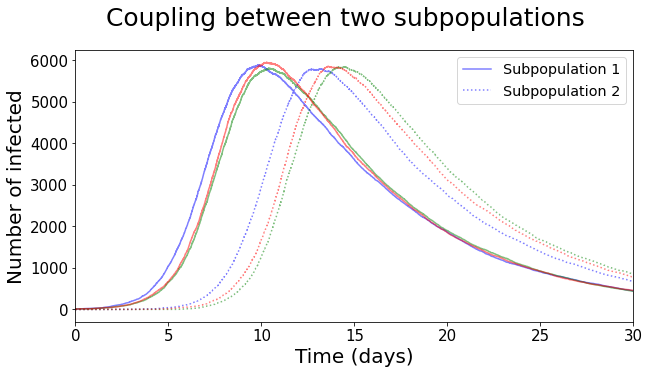

In [513]:
beta=1
gamma=1/7.0
mu=0
N0=10000
rhoij = 0.01
nsub = 2
rho = np.zeros((nsub,nsub))
for pop in range(nsub):
    for sub in range(nsub):
        if pop == sub:
            rho[pop][sub] = 1
            if pop < nsub-1:
                if sub < nsub-1:
                    rho[pop][sub+1] = rhoij
                    rho[pop+1][sub] = rhoij      

print(rho)
ND=MaxTime=365.0
Y01=10
X01=N0-Y01
# Y01=pl.ceil(mu*N0/gamma)
# X01=pl.floor(gamma*N0/beta)
Z01=N0-X01-Y01

Y02=0
X02=N0-Y02
# Y02=0
# X02=pl.floor(gamma*N0/beta)
Z02=N0-X02-Y02

INPUT01 = [[X01,Y01,Z01]]
INPUT = INPUT01 + [[X02,Y02,Z02] for x in range(nsub-1)]
# print(INPUT)


timestep=0.0
linestyles = ['-', ":", '--', '-.']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (10,5))

for i in range(3):
    INPUT = INPUT01 + [[X02,Y02,Z02] for x in range(nsub-1)]
    [T,S,I,R]=Stoch_Iteration_met(INPUT)
    
    tT=T
    tS=S
    tI=I
    tR=R
    for sub in range(nsub):
        if i == 0:
            ax2.plot(tT[1:], tI[sub][1:], alpha = 0.5, color = colors[i], linestyle = linestyles[sub], label=('Subpopulation {}'.format(sub+1, i+1)))
        else:
            ax2.plot(tT[1:], tI[sub][1:], alpha = 0.5, color = colors[i], linestyle = linestyles[sub])
        
ax2.set_ylabel("Number of infected", size = 20)
ax2.set_xlim(0,30)
plt.legend(loc = "upper right", fontsize = "x-large")
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
fig.suptitle('Coupling between two subpopulations', size = 25, y = 1.0)
plt.xlabel ('Time (days)', size = 20)
plt.show()

## Part 2

[[1.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [1.e-04 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-04 1.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-04 1.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-04 1.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-04 1.e+00]]


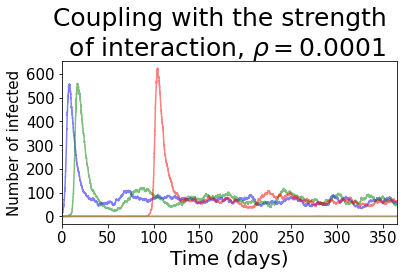

In [523]:
beta=1
gamma=1/7.0
mu=1/70
N0=1000
rhoij = 0.0001
nsub = 6
rho = np.zeros((nsub,nsub))
for pop in range(nsub):
    for sub in range(nsub):
        if pop == sub:
            rho[pop][sub] = 1
            if pop < nsub-1:
                rho[pop+1][sub] = rhoij          
            
print(rho)
ND=MaxTime=365.0
Y01=10
X01=N0-Y01
# Y01=pl.ceil(mu*N0/gamma)
# X01=pl.floor(gamma*N0/beta)
Z01=N0-X01-Y01

Y02=0
X02=N0-Y02
# Y02=0
# X02=pl.floor(gamma*N0/beta)
Z02=N0-X02-Y02

INPUT01 = [[X01,Y01,Z01]]
INPUT = INPUT01 + [[X02,Y02,Z02] for x in range(nsub-1)]
# print(INPUT)


timestep=0.0
linestyles = ['-', ":", '--', '-.']
colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, (ax2) = plt.subplots(1, sharex=True, figsize = (6,3))

for i in range(1):
    INPUT = INPUT01 + [[X02,Y02,Z02] for x in range(nsub-1)]
#     print(INPUT)
    [T,S,I,R]=Stoch_Iteration_met(INPUT)
    
    tT=T
    tS=S
    tI=I
    tR=R
    for sub in range(nsub):
        if i == 0:
            ax2.plot(tT[1:], tI[sub][1:], alpha = 0.5, color = colors[sub], linestyle = linestyles[i], label=('Subpop. {}'.format(sub+1)))
        else:
            ax2.plot(tT[1:], tI[sub][1:], alpha = 0.5, color = colors[sub], linestyle = linestyles[i])
        
ax2.set_ylabel("Number of infected", size = 15)
ax2.set_xlim(0,365)

    
# plt.legend(loc = "upper right", fontsize = "x-large", bbox_to_anchor = (1.43,1))
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
# for tick in ax3.yaxis.get_major_ticks():
#     tick.label.set_fontsize(15)
fig.suptitle('Coupling with the strength \n of interaction, $\N{greek small letter rho} = {}$'.format(rhoij), size = 25, y = 1.13)
plt.xlabel ('Time (days)', size = 20)
plt.show()